In [2]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from survLime.datasets.load_datasets import RandomSurvivalData
from survLime import survlime_tabular
from survLime.scripts.experiment_1 import create_clusters
from survLime.utils.generic_utils import compare_survival_times,compare_cum_hazard_curves

np.random.seed(42)

# Create clusters can be found in scripts/experiment_1
cluster_0, cluster_1 = create_clusters()
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(cluster_0[0], cluster_0[1], test_size=0.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Train bb model
columns =['one']
model = CoxPHSurvivalAnalysis(alpha=0.0001)
model.fit(x_train_1, y_train_1)
model.feature_names_in_ = columns # This is needed in order to compare survival times later

# Obtain a test point to use for prediction
test_point = x_test_1[0]

In [29]:
# We instantiate an explainer (found in survlime_tabular)

# ['one','two',' three', 'four', 'five']

explainer = survlime_tabular.LimeTabularExplainer(x_train_1, y_train_1,
                                                  feature_names= columns,
                                                  class_names=None, 
                                                  categorical_features=None,
                                                  verbose=True, discretize_continuous=False)
num_neighbours = 10000
# From here we are only using log_correction, Ho_t_ and inverse 
H_i_j_wc, weights, log_correction, Ho_t_, scaled_data, inverse, distances = explainer.explain_instance(test_point
                                                                ,model.predict_cumulative_hazard_function,
                                                            num_samples = num_neighbours)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


## From this cell onwards we construct the matrices
We need 
* H, 
* H0
* b
* weights 
* delta_t

In [25]:
# Constants
epsilon = 0.000001
m = len(times_to_fill)

# Variable of interest
b = cp.Variable(shape=(1,1))

# Compute the H for all the neighbours
yss = model.predict_cumulative_hazard_function(inverse)
H = np.reshape([x.y for x in yss], (num_neighbours, m))
LnH = cp.log(H+epsilon)

# Baseline cumulative hazard 
H0 = np.reshape(Ho_t_, (m,1))
LnH0 = cp.log(H0+epsilon)

# Compute the log correction
logs = np.reshape(log_correction, (num_neighbours, m))



# Distance weights
w = np.reshape(weights, (num_neighbours,1))

# Time differences
t = times_to_fill.copy()
t.append(t[-1]+1)
delta_t = [t[i+1] - t[i] for i in range(m)]
delta_t = np.reshape(np.array(delta_t), newshape=(m, 1))

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [26]:
# Matrices to produce the propper sizes
ones_N = np.ones(shape=(num_neighbours, 1))
ones_m_1 = np.ones(shape=(m, 1))

logs_sq = cp.square(logs)
B = ones_N @ LnH0.T
C = LnH-B
Z = scaled_data@b
D = Z@ones_m_1.T

E = C - D
E_sq = cp.square(E)
F = cp.multiply(logs_sq, E_sq)
G = F@ delta_t
funct = G.T@w
objective = cp.Minimize(funct)
prob = cp.Problem(objective)
result = prob.solve(verbose=False)

In [27]:
funct.value

array([[6.98837568e+10]])

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


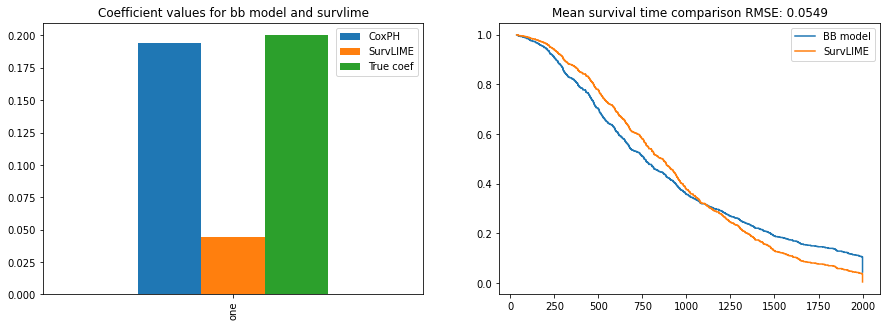

In [28]:
# Coefficient coppied from survLime/scripts/experiment_1.create_clusters
coefficients = [0.2]# [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)] 
values = [x[0] for x in b.value]
compare_survival_times(model, values, x_train_1, y_train_1, x_test_1, true_coef=coefficients)

In [30]:
# Good luck

[autoreload of survLime.utils.generic_utils failed: Traceback (most recent call last):
  File "/home/carlos.hernandez/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/carlos.hernandez/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 844, in exec_module
  File "<frozen importlib._bootstrap_external>", line 981, in get_code
  File "<frozen importlib._bootstrap_external>", line 911, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/carlos.hernandez/PhD/SurvLIME/